## **CNN for Time Series**

CNNs are used for image classification, but they can be applied to time series. The filters can be used as features.

In [ ]:
## Walmart Stock Price
## Ticker: WMT
import yfinance as yf

df = yf.download("WMT", start = "2015-01-01", end = "2024-5-6")
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,28.756666,28.906668,28.516666,28.633333,23.641941,13505400
2015-01-05,28.573334,28.773333,28.503332,28.549999,23.573139,20937000
2015-01-06,28.660000,28.916668,28.596666,28.770000,23.754797,24615300
2015-01-07,28.926666,29.559999,28.889999,29.533333,24.385054,25495200
2015-01-08,29.736668,30.223333,29.690001,30.156668,24.899729,38140800


<Axes: xlabel='Date'>

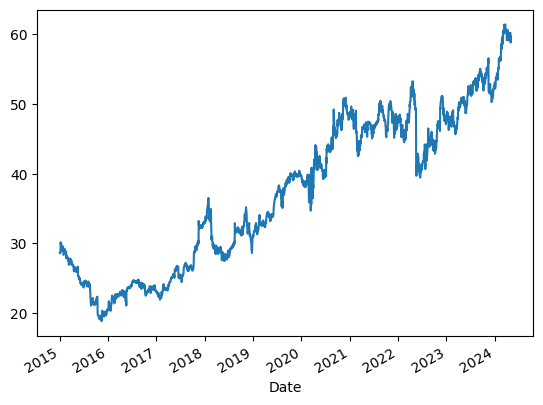

In [ ]:
## plot
df['Close'].plot()

In [ ]:
## train/test split
train = df['Close'][:"2023-12-31"]
test = df['Close']["2023-12-31":]

In [ ]:
## standardize the data
## vanishing gradient or exploding gradient
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train.values.reshape(-1,1))

scaled_train = scaler.transform(train.values.reshape(-1,1))
scaled_test = scaler.transform(test.values.reshape(-1,1))

In [ ]:
## You can use the TimeSeriesGenerator from keras to create the lagged values
## this creates a generator (X_train, y_train)

import numpy as np
def split_sequence(sequence, n_steps):
 X, y = list(), list()
 for i in range(len(sequence)):
 # find the end of this pattern
  end_ix = i + n_steps
 # check if we are beyond the sequence
  if end_ix > len(sequence)-1:
    break
 # gather input and output parts of the pattern
  seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

In [ ]:
## X_train and y_train
X_train, y_train = split_sequence(scaled_train, 5) ## 5 lags
X_test, y_test = split_sequence(scaled_test, 5)

In [ ]:
## RNN Architecture
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense  ## LSTM, GRU

rnn = Sequential()
rnn.add(SimpleRNN(units = 60, input_shape = (5,1), activation = "relu", return_sequences = True))  ## input_shape(lags, 1)
rnn.add(SimpleRNN(units = 30, activation = "relu"))  ## return_sequences = False (flatten)
rnn.add(Dense(30, activation = "relu"))
rnn.add(Dense(1)) ## default is linear

In [ ]:
## COMPILE
rnn.compile(optimizer = "adam", loss = "mse")

In [ ]:
## EARLY STOPPING
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = "val_loss", patience = 10)

In [ ]:
## FIT
rnn.fit(X_train, y_train, epochs = 100, batch_size = 100, validation_data = (X_test, y_test))

Epoch 1/100
23/23 [==============================] - 4s 25ms/step - loss: 0.4283 - val_loss: 0.1315
Epoch 2/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0148 - val_loss: 0.0061
Epoch 3/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0223
Epoch 4/100
23/23 [==============================] - 0s 8ms/step - loss: 0.0036 - val_loss: 0.0046
Epoch 5/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 6/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 7/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0030 - val_loss: 0.0067
Epoch 8/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0078
Epoch 9/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0055
Epoch 10/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 11

In [ ]:
## predictions

predictions = scaler.inverse_transform(rnn.predict(X_test))

3/3 [==============================] - 0s 15ms/step


## **XGBoost**

You need to create the lags

In [ ]:
## Suppose you want to create lags for close
import numpy as np
vars = ['Close']
l = 5

for col in vars:
  lags = np.arange(1,l,1)
  for lag in lags:
    df["{}_Lag{}".format(col, lag)] = df[col].transform(lambda x: x.shift(lag))


In [ ]:
## drop ALL predictors NOT LAGGED
## except for the Y VARIABLE (CLOSE)
df.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis = 1)  ## inplace = True

,Close,Close_Lag1,Close_Lag2,Close_Lag3,Close_Lag4
Date,,,,,
2015-01-02,28.633333,NaN,NaN,NaN,NaN
2015-01-05,28.549999,28.633333,NaN,NaN,NaN
2015-01-06,28.770000,28.549999,28.633333,NaN,NaN
2015-01-07,29.533333,28.770000,28.549999,28.633333,NaN
2015-01-08,30.156668,29.533333,28.770000,28.549999,28.633333
...,...,...,...,...,...
2024-04-26,60.160000,60.209999,59.869999,59.090000,60.139999
2024-04-29,60.240002,60.160000,60.209999,59.869999,59.090000
2024-04-30,59.349998,60.240002,60.160000,60.209999,59.869999


In [ ]:
## USE CODE TO FIT YOUR MODELS TO COMPARE TO

## **CNN for TIME SERIES**